Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/master/LICENSE.md)


# Building a scan programmatically for a multiclass classification use case

In this notebook we will build local multiclass classification models that predict the presence of heart disease (angiographic disease status), and we will run two scans framing the use case as a partitioned and ordered multiclass classification tasks respectively. Each scan will include Robustness, Fairness, Explainability, Explanation, and Performance. 

The dataset used in this notebook is originally from: http://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import numpy as np
import random
import pprint

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from certifai.common.utils.encoding import CatEncoder
from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource, CertifaiGroupingBucket,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.scanner.explanation_utils import explanations, construct_explanations_dataframe

In [2]:
# Prepare datasets for test/train split
base_path = '..'
all_data_file = f"{base_path}/datasets/heart_disease_multiclass-prepped.csv"
RANDOM_SEED = 42

df = pd.read_csv(all_data_file)

cat_columns = [
    "sex",
    "fbs",
    "exang"
]
label_column = "class_att"


Y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

encoder = CatEncoder(cat_columns, X)

# Train models

def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model


svm_model = build_model((encoder(X_train.values), Y_train),
                          "SVM",
                          "SVM",
                          (encoder(X_test.values), Y_test))

logistic_model = build_model((encoder(X_train.values), Y_train),
                          "logistic",
                          "logistic",
                          (encoder(X_test.values), Y_test))

Model 'SVM' accuracy is 0.6166666666666667
Model 'logistic' accuracy is 0.6166666666666667


In [3]:
# Wrap the model up for use by Certifai as a local model
svm_model_proxy = CertifaiPredictorWrapper(svm_model, encoder=encoder)
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model, encoder=encoder)

## Running a scan as a partitioned multiclass classification use case

In a partitioned multiclass classfication use case, prediction outcomes are explictly labeled as either favorable or unfavorable and are thusly partitioned into two groups. Similar to binary-classification, at most a single counterfactual will be produced per observation in the explanation report with a changing prediction from the favorable group to the unfavorable group or vice-versa.

For this scan we will consider the prediction outcome of 0 ("Heart disease not detected") in the favorable group and prediction outcomes 1,2,3,4 as being in the unfavorable group.

In [4]:
# Create the scan object from scratch using the ScanBuilder class

# Below we create the prediction task, and set the `prediction_favorability` to `explicit`. This specifies
# that individual outcomes will be labeled as favorable or unfavorable. We also set names for the favorable and
# unfavorable outcome groups.
partitioned_task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(0, name="Heart disease not detected", favorable=True),
        CertifaiOutcomeValue(1, name='Stage 1: > 50% diameter narrowing in a major vessel'),
        CertifaiOutcomeValue(2, name='Stage 2: > 50% diameter narrowing in a major vessel'),
        CertifaiOutcomeValue(3, name='Stage 3: > 50% diameter narrowing in a major vessel'),
        CertifaiOutcomeValue(4, name='Stage 4: > 50% diameter narrowing in a major vessel'),
    ],
    prediction_favorability='explicit',
    favorable_outcome_group_name="Heart disease not detected",
    unfavorable_outcome_group_name="Heart disease detected"),
    prediction_description='Indicator of heart disease level (angiographic disease status)')

scan = CertifaiScanBuilder.create("multiclass_test_use_case",
                                  prediction_task=partitioned_task)

## Add models
first_model = CertifaiModel('SVM', local_predictor=svm_model_proxy)
scan.add_model(first_model)

second_model = CertifaiModel('logistic', local_predictor=logistic_model_proxy)
scan.add_model(second_model)

## Add datasets
eval_dataset = CertifaiDataset('evaluation', CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)
scan.evaluation_dataset_id = 'evaluation'

# Use a small sample from the evaluation dataset as our explanation dataset
expl_df = df.sample(n=10, random_state=RANDOM_SEED)
explan_dataset = CertifaiDataset('explanation', CertifaiDatasetSource.dataframe(expl_df))
scan.add_dataset(explan_dataset)
scan.explanation_dataset_id = 'explanation'

test_df = pd.concat([X_test, Y_test], axis=1)
test_dataset = CertifaiDataset('test', CertifaiDatasetSource.dataframe(test_df))
scan.add_dataset(test_dataset)
scan.test_dataset_id = 'test'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'class_att'

## Add evaluation types
scan.add_evaluation_type('robustness')
scan.add_evaluation_type('explainability')
scan.add_evaluation_type('explanation')

# We'll look at disparity between groups defined by 'sex' in the fairness evaluation
scan.add_evaluation_type('fairness')
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('sex'))

scan.add_evaluation_type('performance')
scan.add_metric(CertifaiModelMetric('accuracy', 'accuracy'))
scan.atx_performance_metric = 'accuracy'

In [5]:
# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'local_reports' directory relative to this notebook. This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
partitioned_results = scan.run(write_reports=False)

Starting scan with model_use_case_id: 'multiclass_test_use_case' and scan_id: '436f4ab7a9c3'
[--------------------] 2020-10-22 20:07:30.205899 - 0 of 10 reports (0.0% complete) - Running robustness evaluation for model: SVM
[##------------------] 2020-10-22 20:08:16.594123 - 1 of 10 reports (10.0% complete) - Running explainability evaluation for model: SVM
[####----------------] 2020-10-22 20:09:04.282377 - 2 of 10 reports (20.0% complete) - Running explanation evaluation for model: SVM


2020-10-22 20:09:10,144 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'sex_female' with 96 samples)


[######--------------] 2020-10-22 20:09:10.138699 - 3 of 10 reports (30.0% complete) - Running fairness evaluation for model: SVM


2020-10-22 20:09:35,293 root   WARNING  Examples of protected class ('sex', 'sex_female') exhausted before convergence after 96 samples
2020-10-22 20:09:49,903 root   WARNING  Examples of protected class ('sex', 'sex_male') exhausted before convergence after 201 samples


[########------------] 2020-10-22 20:09:51.905751 - 4 of 10 reports (40.0% complete) - Running performance evaluation for model: SVM
[##########----------] 2020-10-22 20:09:51.911672 - 5 of 10 reports (50.0% complete) - Running robustness evaluation for model: logistic
[############--------] 2020-10-22 20:10:43.584439 - 6 of 10 reports (60.0% complete) - Running explainability evaluation for model: logistic
[##############------] 2020-10-22 20:11:28.512049 - 7 of 10 reports (70.0% complete) - Running explanation evaluation for model: logistic


2020-10-22 20:11:34,601 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'sex_female' with 96 samples)


[################----] 2020-10-22 20:11:34.596168 - 8 of 10 reports (80.0% complete) - Running fairness evaluation for model: logistic


2020-10-22 20:12:00,267 root   WARNING  Examples of protected class ('sex', 'sex_female') exhausted before convergence after 96 samples
2020-10-22 20:12:16,082 root   WARNING  Examples of protected class ('sex', 'sex_male') exhausted before convergence after 201 samples


[##################--] 2020-10-22 20:12:18.302682 - 9 of 10 reports (90.0% complete) - Running performance evaluation for model: logistic
[####################] 2020-10-22 20:12:18.307086 - 10 of 10 reports (100.0% complete) - Completed all evaluations


### Notes on the partitioned multiclass scan

The above scan produced various warnings related to the classes within the fairness grouping feature `sex`. These warnings are to be expected for this use case, and can be attributed to the small size of the evaluation dataset (almost 300 rows) as well as the feature distributions within the dataset. The above warnings are alerting that there were not enough samples of each protected class within the `sex` feature for Certifai's genetic algorithm to converge towards the optimal counterfactuals during the fairness evaluation, which will affect the fairness scores and confidence intervals.

These warnings will also be produced when re-running this scan as an ordered multiclass classification use case.

,context,robustness,robustness lower bound,robustness upper bound
SVM,SVM,57.700632,53.628532,61.576806
logistic,logistic,64.089915,60.529876,67.734335


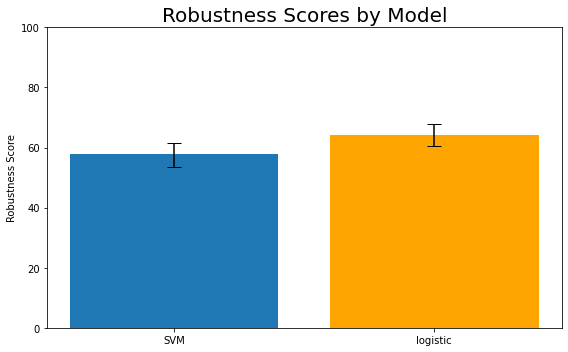

In [6]:
partitioned_robustness_df = construct_scores_dataframe(scores("robustness", partitioned_results))
display(partitioned_robustness_df)

%matplotlib inline

def plot_robustness_scores(robustness_df):
    labels = robustness_df['context'].values
    robustness_scores = robustness_df.iloc[:, 1].values
    lower_errors = robustness_scores - robustness_df.iloc[:, 2].values
    upper_errors = robustness_df.iloc[:, 3].values - robustness_scores
    x = np.arange(len(labels))

    fig, axs = plt.subplots(figsize=[8,5])
    axs.set_title("Robustness Scores by Model", fontsize=20)
    width = 0.8

    rect1 = axs.bar(x, robustness_scores, width, yerr=[lower_errors, upper_errors], capsize=7)
    rect1[1].set_color('orange')

    axs.set_ylim(top=100)
    axs.set_ylabel('Robustness Score')
    axs.set_xticks(x)
    axs.set_xticklabels(labels)

    fig.tight_layout()
    plt.show()

plot_robustness_scores(partitioned_robustness_df)

,context,explainability,Num features (1),Num features (10),Num features (2),Num features (3),Num features (4),Num features (5),Num features (6),Num features (7),Num features (8),Num features (9)
SVM,SVM,87.617188,43.75000,0.78125,33.59375,13.28125,7.03125,0.78125,0.00000,0.0,0.78125,0.0
logistic,logistic,87.617188,33.59375,0.00000,41.40625,19.53125,3.90625,0.78125,0.78125,0.0,0.00000,0.0


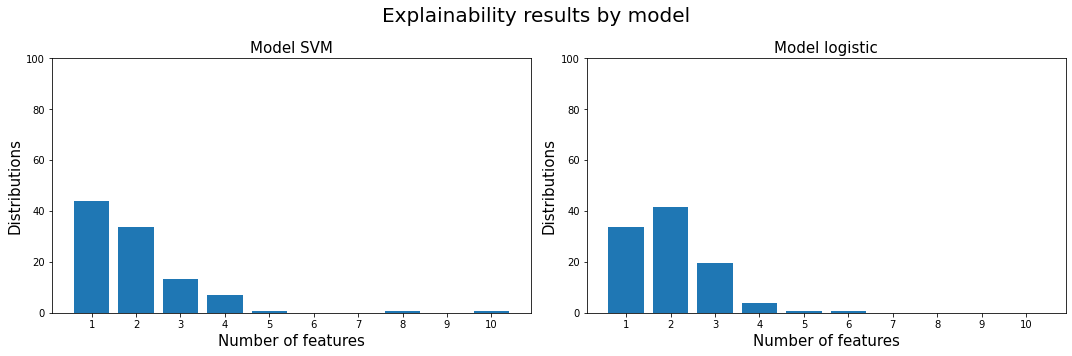

In [7]:
partitioned_explainability_df = construct_scores_dataframe(scores('explainability', partitioned_results))
display(partitioned_explainability_df)

%matplotlib inline

def plot_histogram(axs, explainability_df, model_id):
    num_features = list(range(1, 11))
    columns = [f"Num features ({i})" for i in num_features]
    percentages = explainability_df.loc[model_id, columns].values
    
    axs.bar(num_features, percentages)
    axs.set_xticks(num_features)
    axs.set_xlabel('Number of features', fontsize=15)
    axs.set_title(f"Model {model_id}", fontsize=15)
    axs.set_ylabel('Distributions', fontsize=15)
    axs.set_ylim(top=100)

def plot_explainability_histograms(explainability_df):
    labels = explainability_df['context'].values
    
    fig, (axs1, axs2) = plt.subplots(1, 2, figsize=[15,5])
    fig.suptitle('Explainability results by model', fontsize=20)
    
    plot_histogram(axs1, explainability_df, labels[0])
    plot_histogram(axs2, explainability_df, labels[1])
    
    fig.tight_layout()
    plt.show()
    
plot_explainability_histograms(partitioned_explainability_df)

,context,type in [],fairness,fairness lower bound,fairness upper bound,Feature (sex),Feature (sex) lower bound,Feature (sex) upper bound,type in Feature (sex),Group details (sex_female),Group details (sex_female) lower bound,Group details (sex_female) upper bound,type in Feature (sex),Group details (sex_male),Group details (sex_male) lower bound,Group details (sex_male) upper bound
SVM (burden),SVM,burden,65.086147,43.541297,86.681331,65.086147,43.541297,86.681331,burden,0.048014,0.028592,0.073959,burden,0.099278,0.081769,0.119286
logistic (burden),logistic,burden,50.822802,29.815479,70.975525,50.822802,29.815479,70.975525,burden,0.037112,0.019593,0.058831,burden,0.108886,0.092038,0.130711


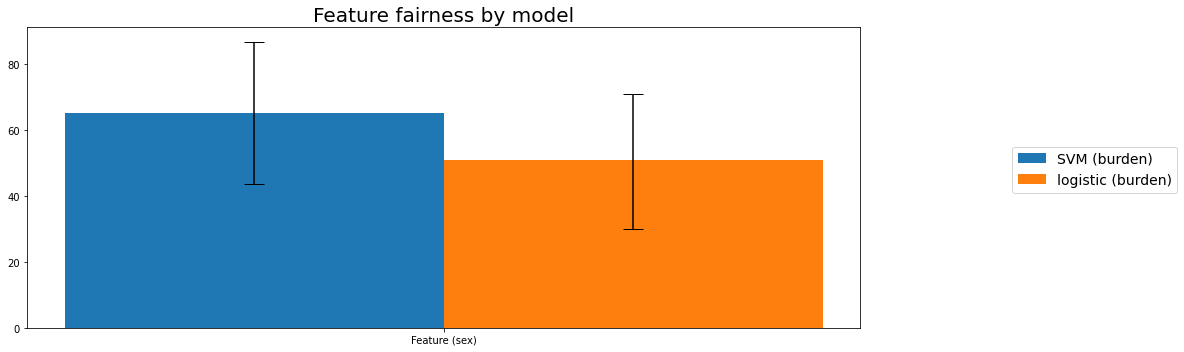

In [8]:
# Display the fairness results of fairness evaluation for both models
partitioned_fairness_df = construct_scores_dataframe(scores("fairness", partitioned_results))
display(partitioned_fairness_df)

%matplotlib inline

def plot_feature_fairness(fairness_df):
    features = ['Feature (sex)']
    feature_scores = fairness_df[features]
    feature_lower_bounds = fairness_df[[f + ' lower bound' for f in features]]
    feature_upper_bounds = fairness_df[[f + ' upper bound' for f in features]]

    fig, ax = plt.subplots(figsize=[15,5])
    ax.set_title('Feature fairness by model', fontsize=20)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
    width = 0.4

    ax.set_xticks(np.arange(len(features))+width)
    ax.set_xticklabels(features)

    for idx in range(len(fairness_df)):
        central_values = list(feature_scores.iloc[idx])
        lower_bounds = list(feature_lower_bounds.iloc[idx])
        upper_bounds = list(feature_upper_bounds.iloc[idx])
        lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
        upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

        ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
                central_values,
                width,
                yerr=[lower_errors, upper_errors],
                color=colors[idx],
                label=fairness_df.index[idx],
                capsize=10)

    fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
    fig.tight_layout()
    fig.subplots_adjust(right=0.8) 
    plt.show()
    
plot_feature_fairness(partitioned_fairness_df)

In [9]:
# Below we will display the Accuracy value computed during the performance evaluation
print('logistic Accuracy: ', partitioned_results['performance']['logistic']['performance_metrics'][0]['value'])
print('SVM Accuracy: ', partitioned_results['performance']['SVM']['performance_metrics'][0]['value'])

logistic Accuracy:  0.6166666666666667
SVM Accuracy:  0.6166666666666667


In [14]:
# Using Certifai's explanation utilities we can programmatically explore counterfactuals produced
# during the explanation evaluation. Below we examine only a single explanation for each model
# by displaying the original input data followed by what features were changed by each
# counterfactual
logistic_explanations = construct_explanations_dataframe(explanations(partitioned_results, model_id='logistic'))
svm_explanations = construct_explanations_dataframe(explanations(partitioned_results, model_id='SVM'))

def display_explanation(df):
    df_original = df[df['instance']=='original'].reset_index(drop=True)
    display(df_original)
    df_cfs = df[df['instance']=='counterfactual'].reset_index(drop=True)
    cf_changes = df_cfs.where(df_cfs != df_original).dropna(axis=1)
    display(pd.concat([df_original[cf_changes.columns], cf_changes]))

### Explanations for logistic Model:

In [15]:
display_explanation(logistic_explanations[logistic_explanations['row'] == 1]) 

,model,row,instance,cf_num,cf_type,prediction,fitness,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,logistic,1,original,0,original prediction,0,0.0,45.0,sex_female,2.0,112.0,160.0,fbs_less_than_120mg/dl,0.0,138.0,exang_no,0.0,2.0,0.0,3.0


,instance,cf_num,cf_type,prediction,fitness,sex,ca
0,original,0,original prediction,0,0.000000,sex_female,0.000000
0,counterfactual,1,prediction changed,1,0.271549,sex_male,2.498713


### Explanations for SVM Model:

In [17]:
display_explanation(svm_explanations[svm_explanations['row'] == 2]) 

,model,row,instance,cf_num,cf_type,prediction,fitness,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,SVM,2,original,0,original prediction,0,0.0,52.0,sex_male,4.0,112.0,230.0,fbs_less_than_120mg/dl,0.0,160.0,exang_no,0.0,1.0,1.0,3.0


,instance,cf_num,cf_type,prediction,fitness,exang,ca
0,original,0,original prediction,0,0.000000,exang_no,1.000000
0,counterfactual,1,prediction changed,1,0.660476,exang_yes,1.478824


## Running a scan as an ordered multiclass classification use case

In an ordered multiclass classification use case prediction outcomes are ordered from most to least favorable. Similar to regression, up to two counterfactuals will be produced per observation in the explanation report, one with increasing favorability and one with decreasing favorability.

For this next scan we will re-use the existing ScanBuilder instance from the last scan and only update prediction task as we'll be performing the same evaluations. We will order the prediction outcomes with the most favorable being 0 ("Heart disease not detected") followed by outcome values 1 - 4 (varying stages of heart disease).

In [18]:
# Below we build the scan for an ordered multiclass classification task
# To do this we set the prediction_favorability to the 'ordered' - this specifies
# that prediction outcomes are ordered MOST to LEAST favorable. We also specify
# the `last_favorable_prediction` value to be only the first possible outcome (no heart disease detected)
prediction_outcomes = [
    CertifaiOutcomeValue(0, name="Heart disease not detected"),
    CertifaiOutcomeValue(1, name='Stage 1: > 50% diameter narrowing in a major vessel'),
    CertifaiOutcomeValue(2, name='Stage 2: > 50% diameter narrowing in a major vessel'),
    CertifaiOutcomeValue(3, name='Stage 3: > 50% diameter narrowing in a major vessel'),
    CertifaiOutcomeValue(4, name='Stage 4: > 50% diameter narrowing in a major vessel'),
]

ordered_task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
        prediction_outcomes,
        prediction_favorability='ordered',
        last_favorable_prediction=prediction_outcomes[0]),
    prediction_description='Indicator of heart disease level (angiographic disease status)')

scan.prediction_task = ordered_task

In [19]:
ordered_results = scan.run(write_reports=False)

[--------------------] 2020-10-22 20:16:15.861848 - 0 of 10 reports (0.0% complete) - Starting scan with model_use_case_id: 'multiclass_test_use_case' and scan_id: '4d2c009b9f38'
[--------------------] 2020-10-22 20:16:15.862015 - 0 of 10 reports (0.0% complete) - Running robustness evaluation for model: SVM
[##------------------] 2020-10-22 20:17:01.413428 - 1 of 10 reports (10.0% complete) - Running explainability evaluation for model: SVM
[####----------------] 2020-10-22 20:18:32.379479 - 2 of 10 reports (20.0% complete) - Running explanation evaluation for model: SVM


2020-10-22 20:18:39,915 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'sex_female' with 96 samples)


[######--------------] 2020-10-22 20:18:39.910524 - 3 of 10 reports (30.0% complete) - Running fairness evaluation for model: SVM


2020-10-22 20:19:09,283 root   WARNING  Examples of protected class ('sex', 'sex_female') exhausted before convergence after 96 samples
2020-10-22 20:19:26,836 root   WARNING  Examples of protected class ('sex', 'sex_male') exhausted before convergence after 201 samples


[########------------] 2020-10-22 20:19:28.678505 - 4 of 10 reports (40.0% complete) - Running performance evaluation for model: SVM
[##########----------] 2020-10-22 20:19:28.682805 - 5 of 10 reports (50.0% complete) - Running robustness evaluation for model: logistic
[############--------] 2020-10-22 20:20:21.914152 - 6 of 10 reports (60.0% complete) - Running explainability evaluation for model: logistic
[##############------] 2020-10-22 20:22:07.798623 - 7 of 10 reports (70.0% complete) - Running explanation evaluation for model: logistic


2020-10-22 20:22:17,217 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'sex_female' with 96 samples)


[################----] 2020-10-22 20:22:17.211972 - 8 of 10 reports (80.0% complete) - Running fairness evaluation for model: logistic


2020-10-22 20:22:49,607 root   WARNING  Examples of protected class ('sex', 'sex_female') exhausted before convergence after 96 samples
2020-10-22 20:23:08,621 root   WARNING  Examples of protected class ('sex', 'sex_male') exhausted before convergence after 201 samples


[##################--] 2020-10-22 20:23:10.758833 - 9 of 10 reports (90.0% complete) - Running performance evaluation for model: logistic
[####################] 2020-10-22 20:23:10.763974 - 10 of 10 reports (100.0% complete) - Completed all evaluations


,context,robustness,robustness lower bound,robustness upper bound
SVM,SVM,57.700632,53.628532,61.576806
logistic,logistic,64.089915,60.529876,67.734335


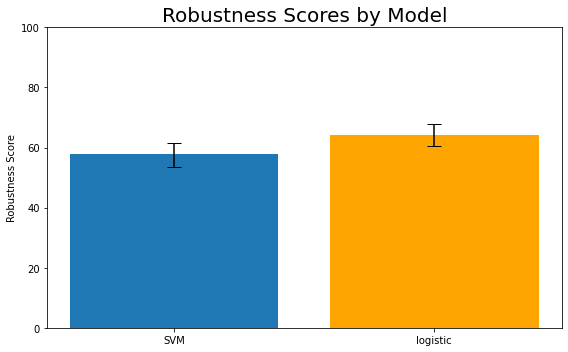

In [20]:
ordered_robustness_df = construct_scores_dataframe(scores("robustness", ordered_results))
display(ordered_robustness_df)

plot_robustness_scores(ordered_robustness_df)

,context,explainability,Num features (1),Num features (10),Num features (2),Num features (3),Num features (4),Num features (5),Num features (6),Num features (7),Num features (8),Num features (9)
SVM,SVM,85.358852,41.148325,0.0,33.014354,15.311005,5.263158,1.913876,1.913876,0.956938,0.00000,0.478469
logistic,logistic,86.523810,52.380952,0.0,22.380952,14.285714,6.190476,0.952381,2.857143,0.476190,0.47619,0.000000


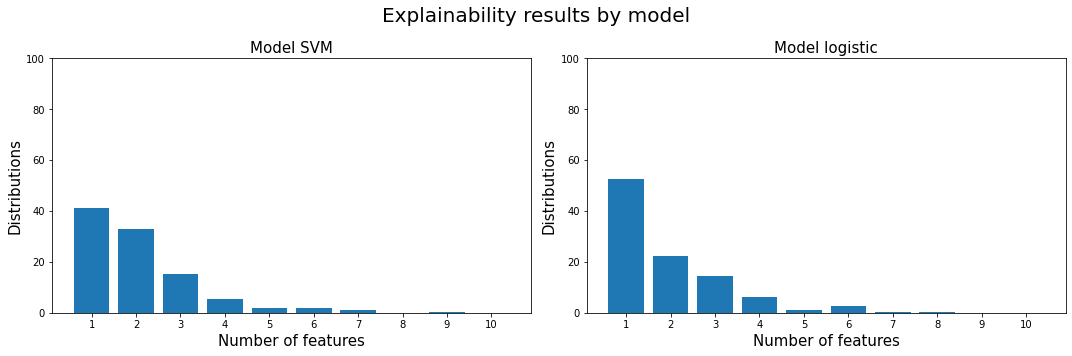

In [21]:
ordered_explainability_df = construct_scores_dataframe(scores('explainability', ordered_results))
display(ordered_explainability_df)

plot_explainability_histograms(ordered_explainability_df)

,context,type in [],fairness,fairness lower bound,fairness upper bound,Feature (sex),Feature (sex) lower bound,Feature (sex) upper bound,type in Feature (sex),Group details (sex_female),Group details (sex_female) lower bound,Group details (sex_female) upper bound,type in Feature (sex),Group details (sex_male),Group details (sex_male) lower bound,Group details (sex_male) upper bound
SVM (burden),SVM,burden,64.813946,42.275234,87.129827,64.813946,42.275234,87.129827,burden,0.043936,0.025621,0.067908,burden,0.092120,0.077723,0.108148
logistic (burden),logistic,burden,48.035892,28.237602,69.733297,48.035892,28.237602,69.733297,burden,0.035046,0.018733,0.057114,burden,0.110655,0.093037,0.129904


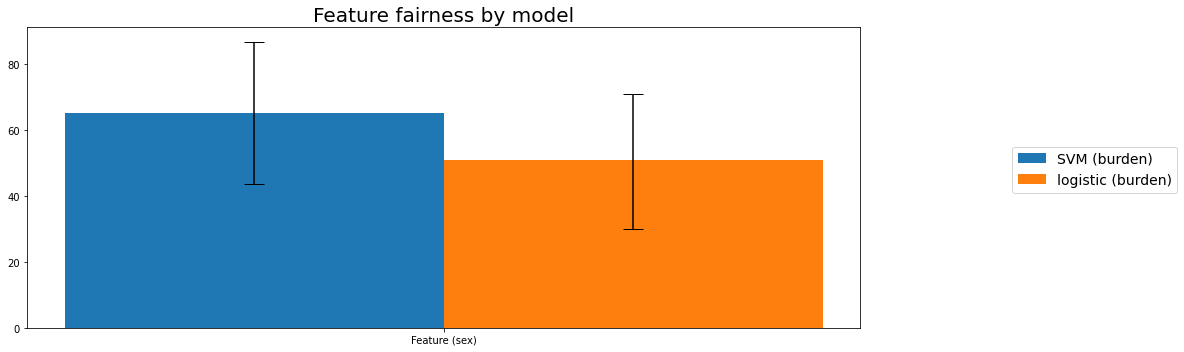

In [22]:
ordered_fairness_df = construct_scores_dataframe(scores("fairness", ordered_results))
display(ordered_fairness_df)

plot_feature_fairness(partitioned_fairness_df)

In [23]:
# Below we will display the Accuracy value computed during the performance evaluation
print('logistic Accuracy: ', partitioned_results['performance']['logistic']['performance_metrics'][0]['value'])
print('SVM Accuracy: ', partitioned_results['performance']['SVM']['performance_metrics'][0]['value'])

logistic Accuracy:  0.6166666666666667
SVM Accuracy:  0.6166666666666667


In [26]:
# For the ordered multiclass use case at most two counterfactuals will produced, one in the
# favorable direction and in the unfavorable direction
logistic_explanations = construct_explanations_dataframe(explanations(partitioned_results, model_id='logistic'))
svm_explanations = construct_explanations_dataframe(explanations(partitioned_results, model_id='SVM'))

### Explanations for logistic Model:

In [27]:
display_explanation(logistic_explanations[logistic_explanations['row'] == 1]) 

,model,row,instance,cf_num,cf_type,prediction,fitness,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,logistic,1,original,0,original prediction,0,0.0,45.0,sex_female,2.0,112.0,160.0,fbs_less_than_120mg/dl,0.0,138.0,exang_no,0.0,2.0,0.0,3.0


,instance,cf_num,cf_type,prediction,fitness,sex,ca
0,original,0,original prediction,0,0.000000,sex_female,0.000000
0,counterfactual,1,prediction changed,1,0.271549,sex_male,2.498713


### Explanations for SVM Model:

In [28]:
display_explanation(svm_explanations[svm_explanations['row'] == 2]) 

,model,row,instance,cf_num,cf_type,prediction,fitness,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,SVM,2,original,0,original prediction,0,0.0,52.0,sex_male,4.0,112.0,230.0,fbs_less_than_120mg/dl,0.0,160.0,exang_no,0.0,1.0,1.0,3.0


,instance,cf_num,cf_type,prediction,fitness,exang,ca
0,original,0,original prediction,0,0.000000,exang_no,1.000000
0,counterfactual,1,prediction changed,1,0.660476,exang_yes,1.478824


### Notes on the ordered multiclass scan 

Although this scan consisted of the same model and datasets as the partitioned multiclass scan, there are differing results between various evaluation due to the different formulations. For example, when comparing the explainability results between scans for the `logistic` model we can notice that counterfactuals generally required fewer feature changes in the ordered scan. This is likely because counterfactuals in the ordered formulation only need to change the predicted outcome to be more or less favorable (e.g. from 3 to 2), whereas in the partitioned formulation counterfactuals need to change the prediction outcome from the favorable group `{0}` to the unfavorable group `{1,2,3,4}` or vice-versa (e.g. from 3 to 0). The smaller changes in the prediction outcomes likely require fewer feature changes, which then explains the difference in explainabily results between scans.

Note, that the difference in formulation doesn't apply to the robustness because robustness is a measure of how well a model retains a specific outcome given small changes in data feature values. Hence, why the robustness scores for both models are consistent between scans. 